# Improving Fine-tuned Model using RAG

Code authored by: Shaw Talebi <br>
Article link: https://towardsdatascience.com/how-to-improve-llms-with-rag-abdc132f76ac <br>
Video link: https://youtu.be/Ylz779Op9Pw?si=iOvBETQDrgoK_sO6 <br>
<br>
Colab: https://colab.research.google.com/drive/1peJukr-9E1zCo1iAalbgDPJmNMydvQms?usp=sharing

### Download the PDF

PDFs are downloaded once and saved in "pdfs" folder.

To donwload from other url, uncomment the codes below

In [1]:
# import os
# import requests
# from bs4 import BeautifulSoup

# # URL of the page to scrape (your provided URL)
# url = 'https://www.emaanlibrary.com/book/tafseer-ibn-kathir-in-english-114-surahs-complete/?ebook-category=ruqya&latest=1'

# # Send HTTP request to get the page content
# response = requests.get(url)

# # Parse the HTML content with BeautifulSoup
# soup = BeautifulSoup(response.content, 'html.parser')

# # Find all <a> tags with href links ending in .pdf
# pdf_links = soup.find_all('a', href=True)
# pdf_urls = []

# # Loop through all links and filter out the ones that are PDFs
# for link in pdf_links:
#     href = link['href']
#     if href.endswith('.pdf'):
#         pdf_urls.append(href if 'http' in href else f'https://www.emaanlibrary.com{href}')

# # Create a folder to store downloaded PDFs
# if not os.path.exists('pdfs'):
#     os.makedirs('pdfs')

# # Download each PDF
# for pdf_url in pdf_urls:
#     pdf_name = pdf_url.split("/")[-1]  # Extract the filename from the URL
#     pdf_path = os.path.join('pdfs', pdf_name)

#     # Send request to download the PDF
#     response = requests.get(pdf_url)
    
#     # Write PDF content to a file
#     with open(pdf_path, 'wb') as pdf_file:
#         pdf_file.write(response.content)
    
#     print(f'Downloaded: {pdf_name}')


### Import Library

In [2]:
# !pip install llama-index
# !pip install llama-index-embeddings-huggingface
# !pip install peft
# !pip install auto-gptq
# !pip install optimum
# !pip install bitsandbytes

In [25]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import StorageContext, load_index_from_storage

from llama_index.vector_stores.faiss import FaissVectorStore
import faiss 

from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
import torch

from transformers import AutoTokenizer

torch.cuda.is_available()

True

### Define Llama Index Settings and Vector Database

The Settings is a bundle of commonly used resources used during the indexing and querying stage in a LlamaIndex workflow/application.

https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/

We initially tried Settings.chunk_size = 120 and Settings.chunk_overlap = 20. However, this process lead to different number of token accross different documents. 

We then tried token based chunking. https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/



In [ ]:
# import any embedding model on HF hub (https://huggingface.co/spaces/mteb/leaderboard)

# Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# 384 dimension
# Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"") # alternative model

# https://www.sbert.net/examples/sentence_transformer/training/multilingual/README.html
Settings.embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    show_progress_bar = True)

# Create a FAISS index manually (FlatL2 = basic exact search)
embedding_dim = 768  # This model outputs 768-dim vectors
faiss_index = faiss.IndexFlatL2(embedding_dim)

# Plug it into the vector store
vector_store = FaissVectorStore(faiss_index=faiss_index)
faiss_store = vector_store

# Set it in LlamaIndex Settings
Settings.vector_store = faiss_store

# tokenizer (use the same one for embedding)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
    
Settings.llm = None
Settings.text_splitter = SentenceSplitter(chunk_size=50, chunk_overlap=10)

### Read and Store Docs into Vector DB

SimpleDirectoryReader is the simplest way to load data from local files into LlamaIndex. For production use cases it's more likely that you'll want to use one of the many Readers available on LlamaHub, but SimpleDirectoryReader is a great way to get started. 
https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/

tqdm is used to tract progress

In [10]:
from tqdm import tqdm 
from time import perf_counter as timer
start_time = timer()

reader = SimpleDirectoryReader(input_dir = "pdfs", recursive = False)
documents = []
for docs in tqdm(reader.iter_data()):
    # <do something with the documents per file>
    documents.extend(docs)

end_time = timer()
print(f"[INFO] Time taken: {end_time-start_time:.5f} seconds.")

116it [05:23,  2.79s/it]

[INFO] Time taken: 323.82692 seconds.


We will create chunk and extract information from each chunk.

In [21]:
docs = []
for ii in tqdm(range(len(documents))):
    file_name = documents[ii].metadata['file_name']
    page = documents[ii].metadata['page_label']
    content = documents[ii].text.replace('\n', '').replace('  ', ' ').replace('\'', '').replace('...', '.')
    page_characters = len(content)
    page_tokens_manual = page_characters/4
    page_tokens = estimate_token_length(content)
    
    docs.append(
        {"file_name": file_name,
         "page": page,
         "content":content,
         "chunk_characters": page_characters,
         "chunk_tokens": page_tokens,
         "chunk_tokens_manual": page_tokens_manual}
    )

100%|██████████| 12055/12055 [00:11<00:00, 1025.13it/s]


In [22]:
import random 
random.sample(docs, 2)

[{'file_name': '040Ghafir.pdf',
  'page': '48',
  'content': ' 48 Allah says: .آَ it is greatly hateful and disgusting to Allah and to those who believe. meaning, the believers too will despise those who are like this, and whoever is like this, Allah will put a seal on his heart so that after that he will not acknowledge anything good or denounce anything evil. Allah says: .آَ Thus does Allah seal up the heart of every arrogant. meaning, so that they cannot follow the truth.  ﺝَ afii64060 tyrant.  وَ ا 40:36 And Fir`awn said: "O Haman! Build me a lofty tower that I may arrive at the ways – أَﺱْ 40:37 The ways of the heavens, afii62808 and I may look upon the God of Musa, but verily, I think him to be a liar. ',
  'chunk_characters': 656,
  'chunk_tokens': 185,
  'chunk_tokens_manual': 164.0},
 {'file_name': '023Muminun.pdf',
  'page': '47',
  'content': ' 47 Then leave Me Alone with such as belie this Quran. We shall punish them gradually from directions they perceive not. And I will g

### Create Pandas dataframe

In [23]:
import pandas as pd
import numpy as np

df = pd.DataFrame(docs)
df.head()

,file_name,page,content,chunk_characters,chunk_tokens,chunk_tokens_manual
0,001Fateh.pdf,1,Revealed in Makkah The Meaning of Al-Fatehah...,644,188,161.00
1,001Fateh.pdf,2,"2 The prayer (i.e., Al-Fatihah ) is divided i...",1298,358,324.50
2,001Fateh.pdf,3,3 The Number of Words and Letters in Al-Fati...,1109,300,277.25
3,001Fateh.pdf,4,"4 Also, Abu Jafar, Muhammad bin Jarir At-Taba...",1076,296,269.00
4,001Fateh.pdf,5,"5 Al-Bukhari, Abu Dawud, An-Nasai and Ibn Maj...",1060,303,265.00


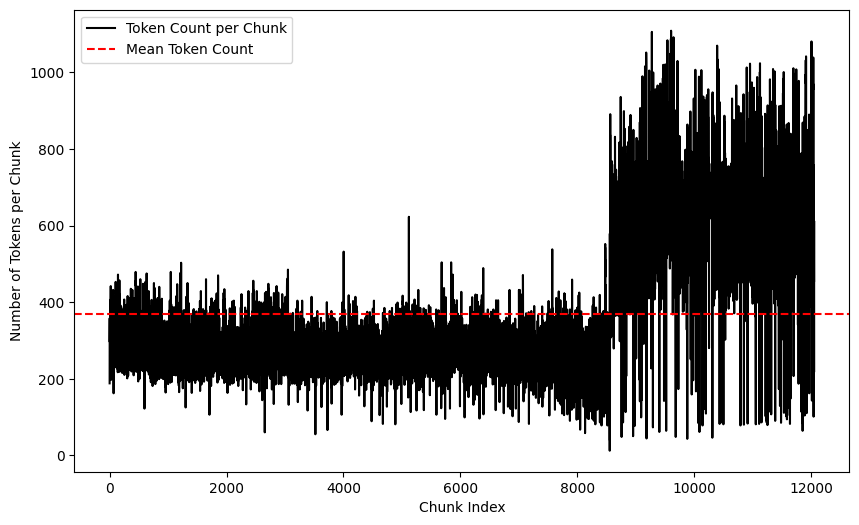

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df["chunk_tokens"], color='k', label="Token Count per Chunk")
plt.axhline(df['chunk_tokens'].mean(), color='red', linestyle='--', label='Mean Token Count')
plt.xlabel("Chunk Index")
plt.ylabel("Number of Tokens per Chunk")
plt.legend()
plt.grid(False)
plt.show()

### Vector database 

An Index is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for retrieval-augmented generation (RAG) use-cases.
Vector Stores are a key component of retrieval-augmented generation (RAG) and so you will end up using them in nearly every application you make using LlamaIndex, either directly or indirectly.
https://docs.llamaindex.ai/en/stable/module_guides/indexing/vector_store_index/

In [ ]:
# Faiss as vector DB
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# per-index. store docs into vector DB
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

# Persist to disk
index.storage_context.persist(persist_dir= "./pdfs")

Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.
Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.
Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.
Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.
Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your metadata to avoid this.
Metadata length (24) is close to chunk size (50). Resulting chunks are less than 50 tokens

# Reload Saved Documents

In [ ]:
import faiss

# Set same embedding model
Settings.embed_model = HuggingFaceEmbedding(
    # model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)

# Load saved FAISS index
faiss_index = faiss.read_index("./pdfs/vector_store.faiss")
Settings.vector_store = FaissVectorStore(faiss_index=faiss_index)

# Load the index
storage_context = StorageContext.from_defaults(persist_dir="./pdfs")
index = load_index_from_storage(storage_context)

### Set Up Search Function

In [ ]:
# set number of docs to retreive
top_k = 5

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=top_k,
)

In [ ]:
# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.4)],
)

### Retrieve Relevant Docs

In [ ]:
manual_questions = ["What is the minimum amount of wealth a person need to own to pay Jakat",
                    "When did battle of badr occured?",
                    "Who will enter the paradise first?"
]

query_list = manual_questions

# query documents
query = query_list[0]
response = query_engine.query(query)

In [ ]:
# reformat response
context = "Context:\n"
top_k = min(top_k, len(response.source_nodes))  # Make sure top_k doesn't exceed the number of available nodes

for i in range(top_k):
    context = context + response.source_nodes[i].text + "\n\n"

print(context)


### Import LLM

In [ ]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# load fine-tuned model from hub
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"

model_name = "Qwen/Qwen2.5-3B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

# config = PeftConfig.from_pretrained("shawhin/shawgpt-ft")
# model = PeftModel.from_pretrained(model, "shawhin/shawgpt-ft")

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

### Use LLM

In [ ]:

prompt = f"""
    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nNow answer the user query.
    User query: Make sure your answers are as concise as possible. {query}
    Answer:
    """
print(prompt)

In [ ]:
model.eval()

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=512)

print(tokenizer.batch_decode(outputs)[0])

In [ ]:
prompt = f"""
    Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nNow use the following context items to answer the user query:
    {context}
    \nRelevant passages: <extract relevant passages from the context here>
    User query: Make sure your answers are as concise as possible. {query}
    Answer:
"""
print(prompt)

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=512)

print(tokenizer.batch_decode(outputs)[0])